(c) 2025 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [31]:
# Import base libraries
import os
import glob
import gc
import pickle
import warnings

# Import JAX-related libraries
import jax
from jax import random
import jax.numpy as jnp
from numpyro.optim import Adam
import numpyro

# Import numpy for array manipulation
import numpy as np
# Import statsmodels for statistical modeling
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
# Import scipy for special functions
import scipy as sp
# Import library to load h5ad files
import scanpy as sc
# Import pandas for data manipulation
import pandas as pd
# Import scribe
import scribe
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style
scribe.viz.matplotlib_style()

# Import colors
color_palette = scribe.viz.colors()

# Exploratory data analysis of `Zebrahub` datasets

In this notebook, we will perform an exploratory data analysis of the datasets
used in the `Zebrahub` paper. This will give us a sense of the raw data.

## Raw counts exploratory data analysis

Let's begin by listing the raw count files.

In [32]:
# Define data directory
DATA_DIR = f"{scribe.utils.git_root()}/data/zebrahub/count_matrices/*"

# List all files in the data directory
files = sorted(glob.glob(f"{DATA_DIR}/*bc_matrix.h5", recursive=True))

files

['/app/data/zebrahub/count_matrices/TDR18/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR19/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR21/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR22/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR23/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR24/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR25/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR26/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR27/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR28/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR29/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR30/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TDR35/filtered_feature_bc_matrix.h5',
 '/app/data/zebrahub/count_matrices/TD

Let's take a look at the first few rows of the one of the files.

In [33]:
# Silence warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Read the gzipped file
    data = sc.read_10x_h5(files[0])

# Extract the data as a pandas DataFrame
df = data.to_df()

# Print shape
print(df.shape[0])

# Take a look at the first few rows
df.head()

11308


,ptpn12,phtf2,phtf2,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,NC_002333.8,mt-nd5,mt-nd6,NC_002333.21,mt-cyb,NC_002333.22,NC_002333.11,dTomato,mCerulean,EYFP
AAACCCAAGACAAGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGAGGTGCT-1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,15.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCGAAGG-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,20.0,2.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGTCGTAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTGGTTAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0


Let's plot the distribution of total counts per cell.

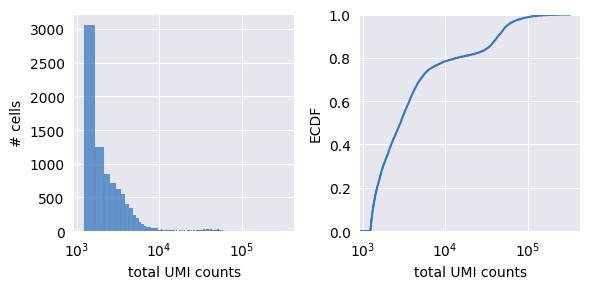

In [43]:
# Initialize figure
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Compute total counts per cell removing the first column (gene names)
total_counts = df.sum(axis=1)

# Plot the distribution of total counts per cell
sns.histplot(total_counts, ax=axes[0], color=color_palette['blue'])
sns.ecdfplot(total_counts, ax=axes[1], color=color_palette['blue'])

# Set title and labels
axes[0].set_xlabel('total UMI counts')
axes[0].set_ylabel('# cells')
axes[1].set_xlabel('total UMI counts')
axes[1].set_ylabel('ECDF')

# Set x-scale to log
axes[0].set_xscale('log')
axes[1].set_xscale('log')

plt.tight_layout()

This distribution has a crazy long tail. Most likely, a negative binomial won't
fit this distribution well. Nevertheless, let's try to fit a negative binomial
to the total counts per cell data.

In [35]:
# Fit Negative Binomial model
model = NegativeBinomial(total_counts.values, np.ones_like(total_counts.values))
result = model.fit()

Optimization terminated successfully.
         Current function value: 10.326508
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7


Let's compare the fitted distribution with the ECDF of the data.

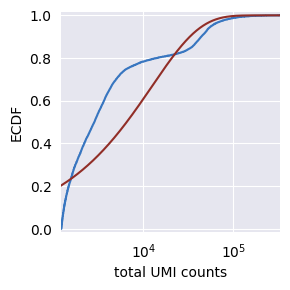

In [42]:
# Extract parameters (note: statsmodels uses different parameterization)
mu = np.exp(result.params[0])  # mean
alpha = result.params[1]  # dispersion parameter
p = 1 / (1 + mu * alpha)  # convert to p parameter
r = 1 / alpha  # convert to r parameter

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Plot ECDF
sns.ecdfplot(total_counts, ax=ax, color=color_palette['blue'])

# Add the fitted distribution
x = np.arange(0, np.max(total_counts), 1)

# Calculate PMF and CDF
cdf = sp.stats.nbinom.cdf(x, n=r, p=p)

# Plot PMF and CDF
ax.plot(x, cdf, color=color_palette['dark_red'], label='Negative Binomial')

# Set title and labels
ax.set_xlabel('total UMI counts')
ax.set_ylabel('ECDF')

# Set x-scale to log
ax.set_xscale('log')

# Set y-scale limits
ax.set_ylim(-0.015, 1.015)

# Set left x-limit to minimum value of total counts
ax.set_xlim(total_counts.min(), np.max(total_counts))

plt.tight_layout()

The fit is not terrible, but the parameter values are very extreme.

Let's now compute the total counts per cell for all the files to then plot the
ECDF.

In [23]:
# Initialize dictionary to store total counts per cell
total_counts_dict = {}

# Loop over all files
for i, file in enumerate(files):
    # Print progress
    if i % 10 == 0:
        print(f"Processing file {i+1} of {len(files)}")

    # Silence warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Read the file
        data = sc.read_10x_h5(file)

    # Extract the data as a pandas DataFrame
    df = data.to_df()

    # Compute total counts per cell removing the first column (gene names)
    total_counts = df.sum(axis=1)

    # Store the total counts in the dictionary
    total_counts_dict[file] = total_counts

Processing file 1 of 40
Processing file 11 of 40
Processing file 21 of 40
Processing file 31 of 40


Now, let's plot the ECDF of the total counts per cell for all the files.

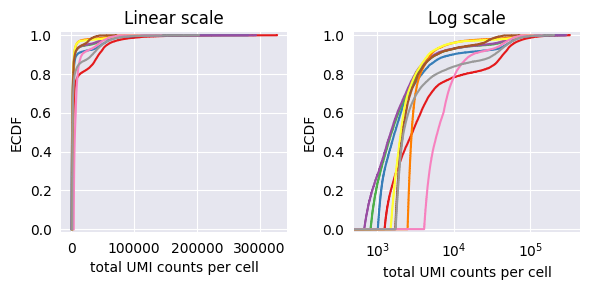

In [24]:
# Initialize figure
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Define colors
colors = sns.color_palette("Set1")

# Loop through keys and values in the dictionary
for (file, total_counts), color in zip(total_counts_dict.items(), colors):
    sns.ecdfplot(total_counts, ax=axes[0], label=file, color=color)
    sns.ecdfplot(total_counts, ax=axes[1], label=file, color=color)

# Set title and labels
axes[0].set_title('Linear scale')
axes[1].set_title('Log scale')
axes[0].set_xlabel('total UMI counts per cell')
axes[0].set_ylabel('ECDF')
axes[1].set_xlabel('total UMI counts per cell')
axes[1].set_ylabel('ECDF')

# Set 2nd axis to log scale
axes[1].set_xscale('log')

# Set y-scale limits
axes[0].set_ylim(-0.015, 1.015)
axes[1].set_ylim(-0.015, 1.015)

plt.tight_layout()


We can see that there's a drastic difference in the total counts per cell between
the different datasets. This makes the normalization scheme extremely important
to make the datasets comparable.

Let's now fit a negative binomial distribution to the total counts per cell for
each dataset.

In [25]:
# Initialize dictionary to store parameters
params_dict = {}

# Loop over total counts per cell
for file, total_counts in total_counts_dict.items():
    # Fit Negative Binomial model
    model = NegativeBinomial(total_counts.values, np.ones_like(total_counts.values))
    result = model.fit(disp=False)

    # Extract parameters (note: statsmodels uses different parameterization)
    mu = np.exp(result.params[0])  # mean
    alpha = result.params[1]  # dispersion parameter
    p = 1 / (1 + mu * alpha)  # convert to p parameter
    r = 1 / alpha  # convert to r parameter

    # Store the parameters in the dictionary
    params_dict[file] = {'r': r, 'p': p}

Now, let's plot the ECDF of the total counts per cell for each dataset and compare
the fitted distribution with the ECDF of the data.


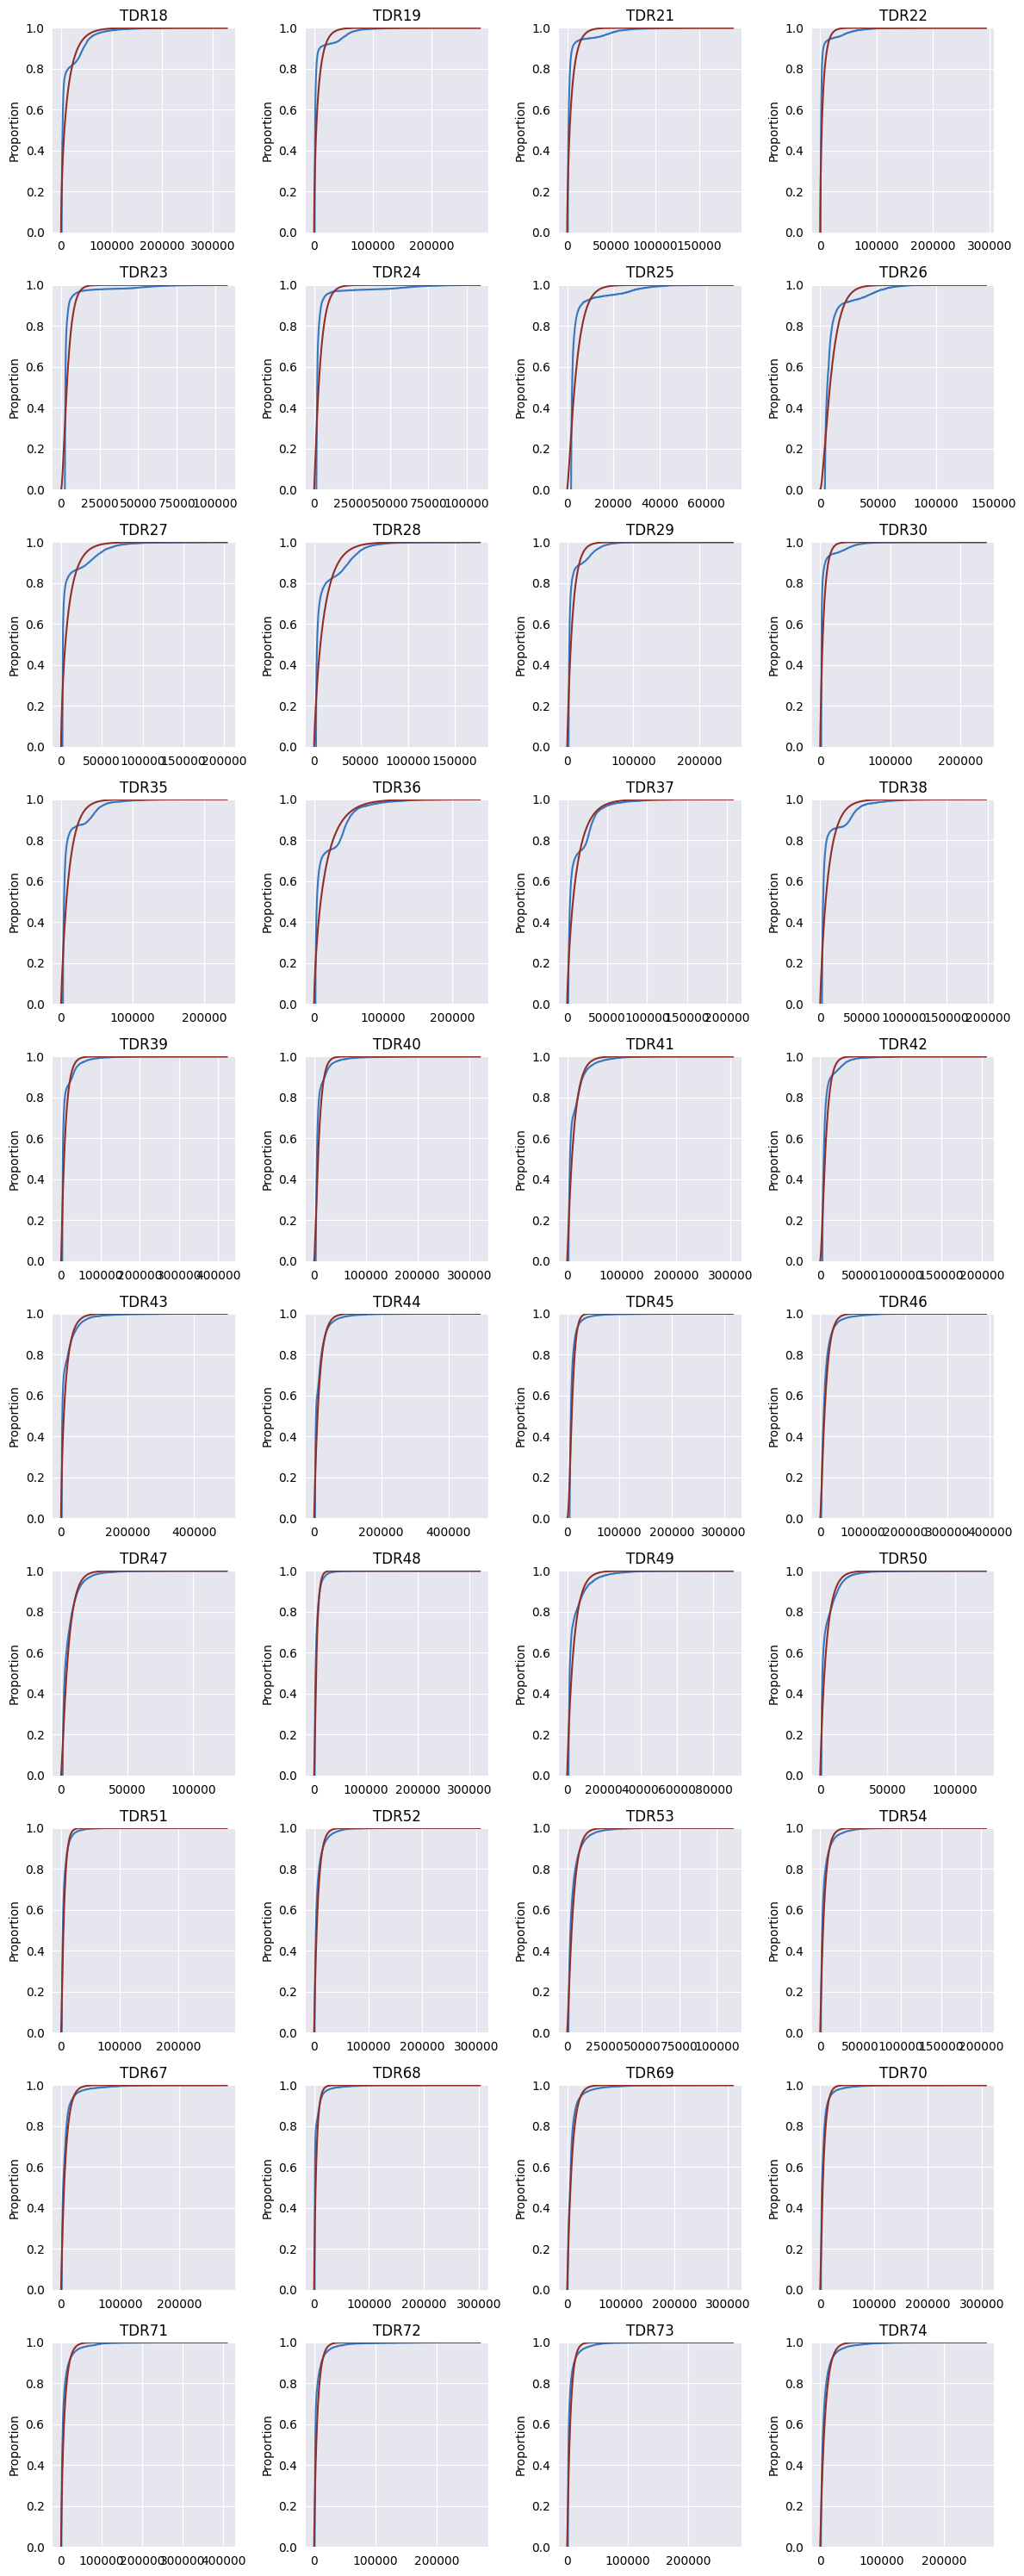

In [30]:
# Get number of datasets
n_datasets = len(total_counts_dict)

# Calculate number of rows and columns needed
n_cols = 4  # We'll keep 4 columns
n_rows = (n_datasets + n_cols - 1) // n_cols  # Ceiling division to get enough rows

# Initialize figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# Flatten axes
axes = axes.flatten()

# Loop over total counts per cell
for (i, (file, total_counts)) in enumerate(total_counts_dict.items()):
    # Plot ECDF
    sns.ecdfplot(total_counts.values, ax=axes[i], color=color_palette['blue'])

    # Add the fitted distribution
    x = np.arange(0, np.max(total_counts), 1)
    # Extract parameters
    r = params_dict[file]['r']
    p = params_dict[file]['p']

    # Calculate PMF and CDF
    cdf = sp.stats.nbinom.cdf(x, n=r, p=p)

    # Plot PMF and CDF
    axes[i].plot(x, cdf, color=color_palette['dark_red'])

    # Extract file name
    file_name = file.split('/')[-2]

    # Add file name as title
    axes[i].set_title(file_name)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()